O Python 3 existente no HackerRank não possui as bibliotecas de redes neurais que geralmente utilizo (Keras como uma interface de alto nível para TensorFlow ou Theano), assim sendo criei um jupyter notebook com a solução utilizando redes neurais do tipo Long short-term Memory (LSTM).

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from keras.callbacks import EarlyStopping, ModelCheckpoint

import numpy as np
import pandas as pd
import random
import sys
from datetime import timedelta
from datetime import datetime
from pandas import DataFrame

import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split

Definir um seed constante para o gerador de número aleatórios; isso garante que o teste é reproduzível.

In [2]:
np.random.seed(7)

O método generate_dataframe gera um dataframe com dados dos últimos *days* dias, gerando uma coluna de número de sessões
para cada um dos dias anteriores.

Por exemplo, para o dia 2012-10-30, se *days* for igual a 5, as *features* geradas para essa data serão dos dias 25 a 29 de outubro de 2012. Se *days* for igual a 1, a *feature* será o número de sessões do dia 29.

In [27]:
initial_date = datetime.strptime('2012-10-01', '%Y-%m-%d')

series = []
with open('in0.txt', 'r') as fh:
    for line in fh:
        series.append(line.strip())
series = np.array(series, dtype=np.float)
        
expected = []
with open('out0.txt', 'r') as fh:
    for line in fh:
        expected.append(line.strip())
expected = np.array(expected, dtype=np.float)


def dataframe_add_shift(df, t):
    key = 'shift_%d' % (t)
    df[key] = df.shift(t)['user_sessions']
    return df


def get_X_y(df):
    df = df.dropna()
    df = df.drop(['date', 'weekday'], axis=1)
    X = df.drop(['user_sessions'], axis=1)
    y = df['user_sessions']
    return X, y


def generate_dataframe(initial_date, series, days):
    series = np.concatenate((series, np.zeros(30)))
    df = DataFrame(series, 
                   columns=['user_sessions'],
                   )
    
    df['user_sessions'] = df['user_sessions'] / 1000
    df['date'] = pd.date_range(initial_date, periods=len(series), freq='D')        
    df['weekday'] = df['date'].dt.weekday_name
   
    for i in range(1, days + 1):
        df = dataframe_add_shift(df, i)

    return df

O método reshape é necessário para adequar os dados de entrada à representação de dimensões esperada pelo LSTM. O método train_and_predict_thirty_days irá calcular os próximos 30 dias baseados nos últimos n dias definidos pelo parâmetro *days*.

As métricas de erro *mean absolute error* e *mean absolute percentage error* foram testadas, mas o melhor resultado foi obtido com *mean squared error*.

In [61]:
def reshape(v):
    v = v.as_matrix()
    return np.reshape(v, (v.shape[0], 1, v.shape[1]))


def train_and_predict_thirty_days(days):
    df = generate_dataframe(initial_date, series, days)
    X, y = get_X_y(df)
    X_train, X_test, y_train, y_test = train_test_split(X[:-30], y[:-30], 
                                                        test_size=0.3, 
                                                        random_state=0)
    
    model = Sequential()
    model.add(LSTM(4, 
                   input_shape=(1, days)
                  ))
    model.add(Dense(16, activation='tanh'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    save_model_checkpoint = ModelCheckpoint('best_model.hdf5', 
                                            save_best_only=True, 
                                            save_weights_only=True)
    model.fit(reshape(X_train),
              y_train,
              validation_data=(reshape(X_test), y_test),
              epochs=100,
              batch_size=16,
              verbose=0,
              callbacks=[early_stopping, save_model_checkpoint]
             )
    model.load_weights('best_model.hdf5')
    
    offset = len(series)
    predicted = []
    # um predict para cada novo dia calculado
    for i in range(-30, 0):
        if i != -1:
            r = model.predict(reshape(X[i:i+1]))
        else:
            r = model.predict(reshape(X[-1:]))
        predicted.append(r[0, 0])
        df.set_value(offset + 30 + i, 'user_sessions', r)

        for i in range(1, days + 1):
            df = dataframe_add_shift(df, i)

        X, y = get_X_y(df)
    predicted = np.array(predicted) * 1000
    
    return predicted

# Passado com 1 dia

In [62]:
%time predicted_1 = train_and_predict_thirty_days(1)

CPU times: user 22.6 s, sys: 1.01 s, total: 23.6 s
Wall time: 16.6 s


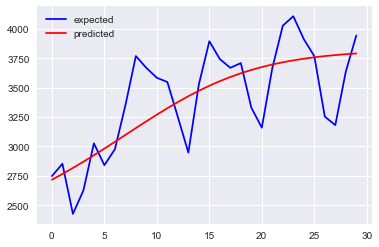

In [63]:
plt.plot(expected, color='blue')
plt.plot(predicted_1, color='red')
plt.legend(['expected', 'predicted'])

# Passado com 7 dias

In [40]:
%time predicted_7 = train_and_predict_thirty_days(7)

CPU times: user 39.5 s, sys: 2.43 s, total: 41.9 s
Wall time: 27.6 s


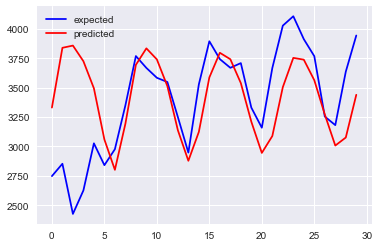

In [41]:
plt.plot(expected, color='blue')
plt.plot(predicted_7, color='red')
plt.legend(['expected', 'predicted'])

# Passado com 30 dias

In [38]:
%time predicted_30 = train_and_predict_thirty_days(30)

CPU times: user 48.3 s, sys: 2.68 s, total: 51 s
Wall time: 33.5 s


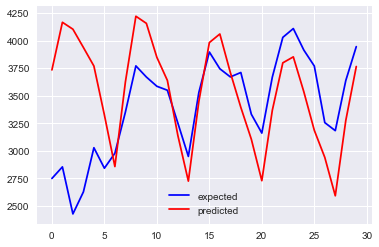

In [39]:
plt.plot(expected, color='blue')
plt.plot(predicted_30, color='red')
plt.legend(['expected', 'predicted'])

# Passado com 60 dias

In [42]:
%time predicted_60 = train_and_predict_thirty_days(60)

CPU times: user 24.4 s, sys: 1.34 s, total: 25.7 s
Wall time: 17.6 s


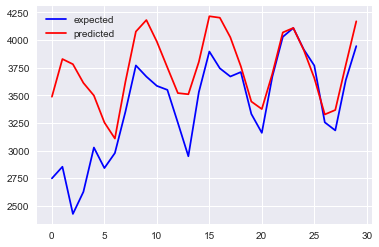

In [43]:
plt.plot(expected, color='blue')
plt.plot(predicted_60, color='red')
plt.legend(['expected', 'predicted'])

# Passado com 90 dias

In [44]:
%time predicted_90 = train_and_predict_thirty_days(90)

CPU times: user 28.9 s, sys: 1.39 s, total: 30.3 s
Wall time: 21.2 s


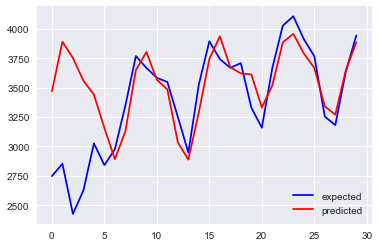

In [45]:
plt.plot(expected, color='blue')
plt.plot(predicted_90, color='red')
plt.legend(['expected', 'predicted'])

# Passado com 120 dias

In [74]:
%time predicted_120 = train_and_predict_thirty_days(120)

CPU times: user 23.7 s, sys: 1.11 s, total: 24.9 s
Wall time: 18.2 s


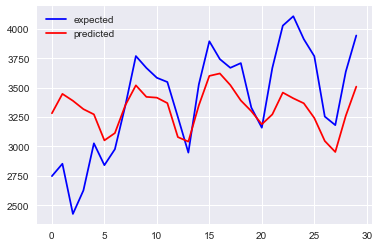

In [75]:
plt.plot(expected, color='blue')
plt.plot(predicted_120, color='red')
plt.legend(['expected', 'predicted'])

# Passado com 150 dias

In [77]:
%time predicted_150 = train_and_predict_thirty_days(150)

CPU times: user 1min 1s, sys: 3.42 s, total: 1min 5s
Wall time: 44.4 s


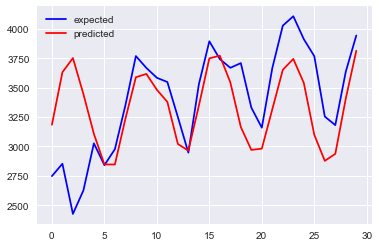

In [78]:
plt.plot(expected, color='blue')
plt.plot(predicted_150, color='red')
plt.legend(['expected', 'predicted'])

# Scores

In [79]:
print('1:', mean_squared_error(expected, predicted_1))
print('7:', mean_squared_error(expected, predicted_7))
print('30:', mean_squared_error(expected, predicted_30))
print('60:', mean_squared_error(expected, predicted_60))
print('90:', mean_squared_error(expected, predicted_90))
print('120:', mean_squared_error(expected, predicted_120))
print('150:', mean_squared_error(expected, predicted_150))

1: 93158.8126509
7: 224718.697573
30: 348118.912119
60: 214353.626261
90: 166460.698874
120: 154056.526228
150: 172663.18947


# Conclusão

Para fins de predição do número de sessões de usuários para um dado dia, os modelos que utiliza passado com 120 dias apresentou o melhor score, mas apenas pelo fato do baixo valor das primeiras cinco medidas. Eu escolheria o modelo treinado com passado fixado em 90 dias.

# Resultados para outra base

Há uma outra base utilizada como exemplo de entrada e saída, cujo comportamento é um tanto curioso: https://hsto.org/files/ab7/8b9/b2c/ab78b9b2cd554132b140028fc97ad510.png. Não consegui resultados satisfatórios para ela utilizando redes neurais.

In [81]:
series = []
with open('in1.txt', 'r') as fh:
    for line in fh:
        series.append(line.strip())
series = np.array(series, dtype=np.float)
        
expected = []
with open('out1.txt', 'r') as fh:
    for line in fh:
        expected.append(line.strip())
expected = np.array(expected, dtype=np.float)

In [87]:
%time predicted_other = train_and_predict_thirty_days(60)

CPU times: user 26.5 s, sys: 1.02 s, total: 27.5 s
Wall time: 20.7 s


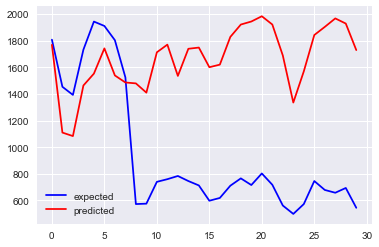

In [88]:
plt.plot(expected, color='blue')
plt.plot(predicted_other, color='red')
plt.legend(['expected', 'predicted'])